In [1]:
import datetime
import earthaccess
import h5py
import xarray as xr
from matplotlib import pyplot

auth = earthaccess.login()

$$
P = E + R + \Delta S
$$

![](./assets/water_budget.png)

[*Image courtesy of the USGS*](https://www.usgs.gov/media/images/components-a-simple-water-budget-part-a-watershed)

---

## Calculating basin-scale precipitation

https://dx.doi.org/10.5067/GPM/IMERG/3B-MONTH/07

In [2]:
import geopandas

basin = geopandas.read_file('/home/arthur.endsley/Downloads/TOPS/YellowstoneRiver_drainage_WSG84.shp')
basin

,features,Name,OfficialID,FlagPAVICS,Source,Area,geometry
0,1,Yellowstone River near Sidney MT,06329500,0,USGS,178964.698805,"POLYGON ((-110.96959 45.9911, -110.96959 45.99..."


<Axes: >

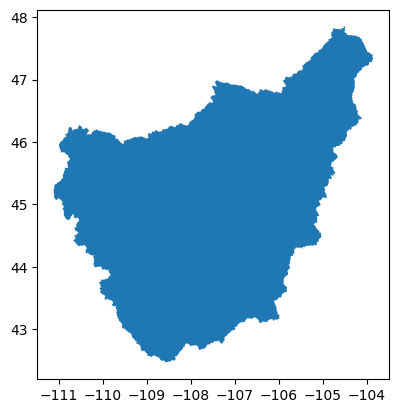

In [3]:
basin.plot()

In [15]:
results = earthaccess.search_data(
    short_name = 'GPM_3IMERGM',
    temporal = ('2018-01-01', '2022-12-31'))

Granules found: 60


In [16]:
earthaccess.download(results, 'data/IMERG-Final')

 Getting 60 granules, approx download size: 1.04 GB


QUEUEING TASKS | :   0%|          | 0/60 [00:00<?, ?it/s]

File 3B-MO.MS.MRG.3IMERG.20180101-S000000-E235959.01.V07B.HDF5 already downloaded
File 3B-MO.MS.MRG.3IMERG.20180201-S000000-E235959.02.V07B.HDF5 already downloaded
File 3B-MO.MS.MRG.3IMERG.20180301-S000000-E235959.03.V07B.HDF5 already downloaded
File 3B-MO.MS.MRG.3IMERG.20180401-S000000-E235959.04.V07B.HDF5 already downloaded
File 3B-MO.MS.MRG.3IMERG.20180501-S000000-E235959.05.V07B.HDF5 already downloaded
File 3B-MO.MS.MRG.3IMERG.20180701-S000000-E235959.07.V07B.HDF5 already downloaded
File 3B-MO.MS.MRG.3IMERG.20180801-S000000-E235959.08.V07B.HDF5 already downloaded
File 3B-MO.MS.MRG.3IMERG.20180601-S000000-E235959.06.V07B.HDF5 already downloaded
File 3B-MO.MS.MRG.3IMERG.20180901-S000000-E235959.09.V07B.HDF5 already downloaded
File 3B-MO.MS.MRG.3IMERG.20181001-S000000-E235959.10.V07B.HDF5 already downloaded
File 3B-MO.MS.MRG.3IMERG.20181101-S000000-E235959.11.V07B.HDF5 already downloaded
File 3B-MO.MS.MRG.3IMERG.20181201-S000000-E235959.12.V07B.HDF5 already downloaded


PROCESSING TASKS | :   0%|          | 0/60 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/60 [00:00<?, ?it/s]

['data/IMERG-Final/3B-MO.MS.MRG.3IMERG.20180101-S000000-E235959.01.V07B.HDF5',
 'data/IMERG-Final/3B-MO.MS.MRG.3IMERG.20180201-S000000-E235959.02.V07B.HDF5',
 'data/IMERG-Final/3B-MO.MS.MRG.3IMERG.20180301-S000000-E235959.03.V07B.HDF5',
 'data/IMERG-Final/3B-MO.MS.MRG.3IMERG.20180401-S000000-E235959.04.V07B.HDF5',
 'data/IMERG-Final/3B-MO.MS.MRG.3IMERG.20180501-S000000-E235959.05.V07B.HDF5',
 'data/IMERG-Final/3B-MO.MS.MRG.3IMERG.20180601-S000000-E235959.06.V07B.HDF5',
 'data/IMERG-Final/3B-MO.MS.MRG.3IMERG.20180701-S000000-E235959.07.V07B.HDF5',
 'data/IMERG-Final/3B-MO.MS.MRG.3IMERG.20180801-S000000-E235959.08.V07B.HDF5',
 'data/IMERG-Final/3B-MO.MS.MRG.3IMERG.20180901-S000000-E235959.09.V07B.HDF5',
 'data/IMERG-Final/3B-MO.MS.MRG.3IMERG.20181001-S000000-E235959.10.V07B.HDF5',
 'data/IMERG-Final/3B-MO.MS.MRG.3IMERG.20181101-S000000-E235959.11.V07B.HDF5',
 'data/IMERG-Final/3B-MO.MS.MRG.3IMERG.20181201-S000000-E235959.12.V07B.HDF5',
 'data/IMERG-Final/3B-MO.MS.MRG.3IMERG.20190101-S000

In [7]:
with h5py.File('data_raw/IMERG-Final/3B-MO.MS.MRG.3IMERG.20180701-S000000-E235959.07.V07B.HDF5', 'r') as hdf:
    longitude = hdf['Grid/lon'][:]
    latitude = hdf['Grid/lat'][:]
    print(longitude.shape)
    print(latitude.shape)
    print(hdf['Grid/precipitation'].shape)
    print(hdf['Grid/precipitation'].attrs['units'])

(3600,)
(1800,)
(1, 3600, 1800)
b'mm/hr'


In [4]:
import glob
file_list = glob.glob('data_raw/IMERG-Final/*.HDF5')
file_list.sort()
len(file_list)

67

In [44]:
file_list[0].split('.')[4][0:8]

'20210101'

In [28]:
for filename in file_list:
    date = datetime.datetime.strptime(filename.split('.')[4][0:8], '%Y%m%d')
    ds = xr.open_dataset(filename, group = 'Grid')
    ds = ds.assign_coords({
        'time': [date], 'lon': longitude, 'lat': latitude
    })
    # Rotate the image data so that latitude is the first (vertical) axis
    ds = ds.transpose('time', 'lat', 'lon', ...)
    ds.get(['precipitation']).to_netcdf(f'data/IMERG-Final_netcdf4/IMERG-Final_{date.strftime("%Y%m%d")}.nc4')

In [74]:
# https://corteva.github.io/geocube/html/examples/zonal_statistics.html

ds.rio.set_spatial_dims(

Help on method set_spatial_dims in module rioxarray.rioxarray:

set_spatial_dims(x_dim: str, y_dim: str, inplace: bool = True) -> Union[xarray.core.dataset.Dataset, xarray.core.dataarray.DataArray] method of rioxarray.raster_dataset.RasterDataset instance
    This sets the spatial dimensions of the dataset.
    
    Parameters
    ----------
    x_dim: str
        The name of the x dimension.
    y_dim: str
        The name of the y dimension.
    inplace: bool, optional
        If True, it will modify the dataframe in place.
        Otherwise it will return a modified copy.
    
    Returns
    -------
    :obj:`xarray.Dataset` | :obj:`xarray.DataArray`:
        Dataset with spatial dimensions set.



In [71]:
ds_clip = ds.rio.clip(basin.geometry.values, basin.crs, from_disk = True)

MissingSpatialDimensionError: x dimension not found. 'rio.set_spatial_dims()' or using 'rename()' to change the dimension name to 'x' can address this.

---

## Obtaining basin-scale runoff data

In [1]:
import xarray as xr

ds = xr.open_dataset('/home/arthur.endsley/Downloads/TOPS/HYSETS_2020_QC_stations.nc')
ds

<xarray.Dataset>
Dimensions:                     (time: 25202, watershed: 14425)
Coordinates:
  * time                        (time) datetime64[ns] 1950-01-01 ... 2018-12-31
Dimensions without coordinates: watershed
Data variables: (12/13)
    watershedID                 (watershed) float64 ...
    drainage_area               (watershed) float64 ...
    drainage_area_GSIM          (watershed) float64 ...
    flag_GSIM_boundaries        (watershed) float64 ...
    flag_artificial_boundaries  (watershed) float64 ...
    centroid_lat                (watershed) float64 ...
    ...                          ...
    elevation                   (watershed) float64 ...
    slope                       (watershed) float64 ...
    discharge                   (watershed, time) float32 ...
    pr                          (watershed, time) float32 ...
    tasmax                      (watershed, time) float32 ...
    tasmin                      (watershed, time) float32 ...
Attributes: (12/13)
    title:          Hydrometeorological Sandbox of the École de technologie s...
    summary:        Hydrometeorological Sandbox of the École de technologie s...
    institution:    Hydrology, Climate and Climate Change Laboratory (HC3) at...
    institute_id:   HC3-ETS
    contact:        Richard Arsenault: richard.arsenault@etsmtl.ca
    date_created:   2020-05-26
    ...             ...
    featureType:    timeSeries
    cdm_data_type:  station
    license:        ODC-BY
    keywords:       HYSETS, GHCND, GSIM, hydrology, North America, streamflow...
    conventions:    CF-1.6, ACDD-1.3
    activity:       HYSETS

In [4]:
ds_2022 = ds.sel(time = slice('2022-01-01', '2022-12-31'))
ds_2022

<xarray.Dataset>
Dimensions:              (time: 365, id: 1)
Coordinates:
  * time                 (time) datetime64[ns] 2022-01-01 ... 2022-12-31
  * id                   (id) int32 4152450
Data variables:
    runoff_mean          (time, id) float32 ...
    area                 (id) float32 ...
    country              (id) <U2 ...
    geo_x                (id) float32 ...
    geo_y                (id) float32 ...
    geo_z                (id) float32 ...
    owneroforiginaldata  (id) <U54 ...
    river_name           (id) <U14 ...
    station_name         (id) <U17 ...
    timezone             (id) float32 ...
Attributes:
    title:          Mean daily discharge (Q)
    Conventions:    CF-1.7
    references:     grdc.bafg.de
    institution:    GRDC
    history:        Download from GRDC Database, 20/09/2024
    missing_value:  -999.000

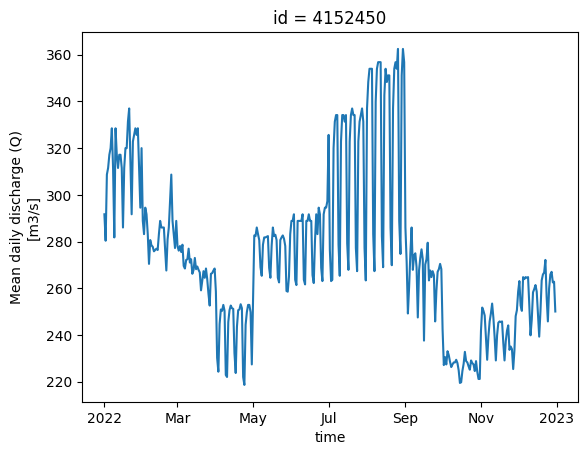

In [8]:
ds_2022['runoff_mean'].plot()

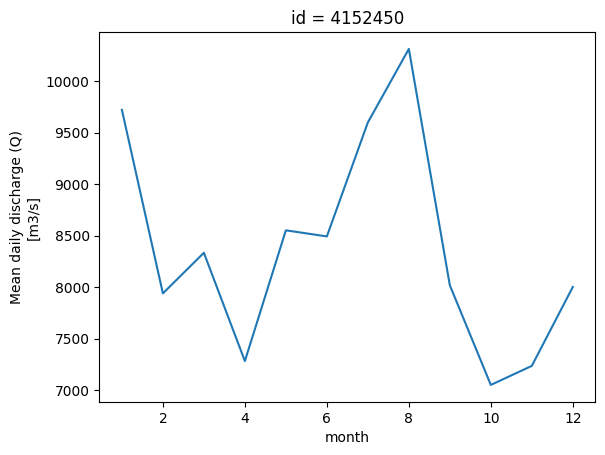

In [10]:
ds_2022['runoff_mean'].groupby('time.month').sum().plot()